# Generate a Lightning Bolt

In [ ]:
import numpy as np
import nibabel as nib

def draw_lightning_bolt(array):
    # Assuming array is a 2D slice from the 3D NIfTI data
    h, w = array.shape
    mid_x = w // 2
    
    # A basic lightning bolt shape
    bolt_height = h // 3
    start_y = (h - bolt_height) // 2
    
    for i in range(bolt_height):
        if i < bolt_height // 2:
            array[start_y + i, mid_x + i // 4] = 1
        else:
            array[start_y + i, mid_x - 3 * (i - bolt_height // 2) // 4] = 1

def generate_lightning_bolt_nifti(img, output_file):
    # Extract data from the input image
    data = img.get_fdata()
    
    # Assuming data is 3D, get the central slice along z-axis
    central_slice_index = data.shape[2] // 2
    
    # Set all values to NaN
    data[:, :, :] = np.nan
    
    # Draw lightning bolt on the central slice
    draw_lightning_bolt(data[:, :, central_slice_index])
    
    # Create and save the new NIfTI file
    new_img = nib.Nifti1Image(data, img.affine, img.header)
    nib.save(new_img, output_file)

# Example usage:
from calvin_utils.nifti_utils.generate_nifti import view_and_save_nifti
from nimlab import datasets as nimds

mni_mask = nimds.get_img("mni_icbm152")
generate_lightning_bolt_nifti(mni_mask, '/Users/cu135/Dropbox (Partners HealthCare)/resources/seeds/artistic/lightning_bolt.nii')


In [ ]:
from nimlab import datasets as nimds
import numpy as np
from PIL import Image
from skimage.measure import find_contours
from skimage.transform import resize
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage.morphology import binary_fill_holes

import numpy as np
from PIL import Image
from skimage.measure import find_contours
from skimage.transform import resize
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage.morphology import binary_fill_holes

class LightningBoltNiftiGenerator:

    def __init__(self, bolt_image_path, fill_mask=True, scaling_factor=1.0):
        self.bolt_image_path = bolt_image_path
        self.scaling_factor = scaling_factor
        self.binary_bolt_mask = self._create_binary_mask()
        self.lightning_bolt_mask_2d = self._generate_2d_bolt_mask(fill_mask)

    def _create_binary_mask(self):
        bolt_image = Image.open(self.bolt_image_path)
        gray_bolt_image = bolt_image.convert("L")
        threshold = 128
        return np.array(gray_bolt_image) > threshold

    def _generate_2d_bolt_mask(self, fill_mask):
        mask_2d = np.zeros_like(self.binary_bolt_mask, dtype=np.float32)
        contours = find_contours(self.binary_bolt_mask, 0.5)
        for contour in contours:
            for point in contour:
                y, x = map(int, point)
                mask_2d[y, x] = 1
        
        if fill_mask:
            mask_2d = binary_fill_holes(mask_2d).astype(np.float32)
        
        # Resize based on scaling factor
        if self.scaling_factor != 1.0:
            new_shape = tuple((np.array(mask_2d.shape) * self.scaling_factor).astype(int))
            mask_2d = resize(mask_2d, new_shape, mode='constant', preserve_range=True)
        
        # Rotate the mask for correct orientation
        mask_2d = np.rot90(mask_2d)
        
        return mask_2d

    def visualize_bolt_mask(self):
        plt.imshow(self.lightning_bolt_mask_2d, cmap='gray')
        plt.axis('off')
        plt.title("2D Lightning Bolt Mask")
        plt.show()

    def generate_nifti_from_mask(self, img, output_file, target_mni_coord=None):
        data = img.get_fdata()
        central_slice_index = data.shape[2] // 2
        data[:, :, :] = np.nan

        # Determine the offset to transform the center of the mask to the target MNI coordinate
        if target_mni_coord:
            y_offset = target_mni_coord[0] - self.lightning_bolt_mask_2d.shape[0] // 2
            x_offset = target_mni_coord[1] - self.lightning_bolt_mask_2d.shape[1] // 2
        else:
            y_offset = (data.shape[0] - self.lightning_bolt_mask_2d.shape[0]) // 2
            x_offset = (data.shape[1] - self.lightning_bolt_mask_2d.shape[1]) // 2

        # Diagnostic prints
        print(f"Initial y_offset: {y_offset}, x_offset: {x_offset}")

        # Ensure the mask is within the bounds of the NIfTI data
        y_offset = max(0, y_offset)
        x_offset = max(0, x_offset)

        y_end = y_offset + self.lightning_bolt_mask_2d.shape[0]
        x_end = x_offset + self.lightning_bolt_mask_2d.shape[1]

        # Adjust the mask boundaries if they go out of bounds
        dy = 0
        dx = 0

        if y_end > data.shape[0]:
            dy = y_end - data.shape[0]

        if x_end > data.shape[1]:
            dx = x_end - data.shape[1]

        # Diagnostic prints
        print(f"Adjusted y_offset: {y_offset}, x_offset: {x_offset}")
        print(f"dy: {dy}, dx: {dx}")

        # Overlay the 2D lightning bolt mask onto the central slice
        data[y_offset:y_offset+self.lightning_bolt_mask_2d.shape[0]-dy, 
            x_offset:x_offset+self.lightning_bolt_mask_2d.shape[1]-dx, 
            central_slice_index] = self.lightning_bolt_mask_2d[:-dy, :-dx]

        new_img = nib.Nifti1Image(data, img.affine, img.header)
        nib.save(new_img, output_file)



In [ ]:
mni_mask = nimds.get_img("mni_icbm152")

# Initialize the generator with the provided image path
generator = LightningBoltNiftiGenerator("/Users/cu135/Dropbox (Partners HealthCare)/resources/seeds/artistic/bolt.jpg", fill_mask=True, scaling_factor=1)

# Visualize the generated 2D lightning bolt mask
generator.visualize_bolt_mask()

# Generate the NIfTI image with the lightning bolt mask
# Here, you can specify a target MNI coordinate to shift the mask's center (e.g., target_mni_coord=(45, 55)).
# If not specified, the mask will be centered in the middle of the brain.
# generator.generate_nifti_from_mask(mni_mask, "/Users/cu135/Dropbox (Partners HealthCare)/resources/seeds/artistic/lightning_bolt.nii", target_mni_coord=(-20, -20))

No Canny

In [ ]:
from nimlab import datasets as nimds
import numpy as np
from PIL import Image
from skimage.measure import find_contours
from skimage.transform import resize
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage.morphology import binary_fill_holes

import numpy as np
from PIL import Image
from skimage.measure import find_contours
from skimage.transform import resize
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage.morphology import binary_fill_holes

class LightningBoltNiftiGenerator:

    def __init__(self, bolt_image_path, fill_mask=True):
        self.bolt_image_path = bolt_image_path
        self.binary_bolt_mask = self._create_binary_mask()
        self.lightning_bolt_mask_2d = None  # will be set later
        self.fill_mask = fill_mask

    def _create_binary_mask(self):
        bolt_image = Image.open(self.bolt_image_path)
        gray_bolt_image = bolt_image.convert("L")
        threshold = 128
        return np.array(gray_bolt_image) > threshold

    def _generate_2d_bolt_mask(self, target_shape, scaling_factor):
        mask_2d = np.zeros_like(self.binary_bolt_mask, dtype=np.float32)
        contours = find_contours(self.binary_bolt_mask, 0.5)
        for contour in contours:
            for point in contour:
                y, x = map(int, point)
                mask_2d[y, x] = 1
        
        if self.fill_mask:
            mask_2d = binary_fill_holes(mask_2d).astype(np.float32)
        
        # Resize based on scaling factor and target shape
        target_height = int(target_shape[0] * scaling_factor)
        target_width = int(target_shape[1] * scaling_factor)
        mask_2d = resize(mask_2d, (target_height, target_width), mode='constant', preserve_range=True)
        
        # Rotate the mask for correct orientation
        mask_2d = np.rot90(mask_2d)
        
        return mask_2d

    def visualize_bolt_mask(self):
        plt.imshow(self.lightning_bolt_mask_2d, cmap='gray')
        plt.axis('off')
        plt.title("2D Lightning Bolt Mask")
        plt.show()

    def generate_nifti_from_mask(self, img, output_file, orientation="axial", target_mni_coord=None, scaling_factor=0.5):
        data = img.get_fdata()
        
        if orientation == "axial":
            target_shape = data.shape[:2]
        elif orientation == "sagittal":
            target_shape = data.shape[1:]
        elif orientation == "coronal":
            target_shape = (data.shape[0], data.shape[2])
        
        # Generate the 2D mask with the specified scaling factor
        self.lightning_bolt_mask_2d = self._generate_2d_bolt_mask(target_shape, scaling_factor)
        
        data[:, :, :] = np.nan

        y_offset, x_offset = self._calculate_offsets(data.shape, orientation, target_mni_coord)
        
        if orientation == "axial":
            slice_index = data.shape[2] // 2
            data[y_offset:y_offset+self.lightning_bolt_mask_2d.shape[0], 
                 x_offset:x_offset+self.lightning_bolt_mask_2d.shape[1], 
                 slice_index] = self.lightning_bolt_mask_2d
        
        elif orientation == "sagittal":
            slice_index = data.shape[0] // 2
            data[slice_index, 
                 x_offset:x_offset+self.lightning_bolt_mask_2d.shape[1], 
                 y_offset:y_offset+self.lightning_bolt_mask_2d.shape[0]] = self.lightning_bolt_mask_2d
        
        elif orientation == "coronal":
            slice_index = data.shape[1] // 2
            data[x_offset:x_offset+self.lightning_bolt_mask_2d.shape[1], 
                 slice_index, 
                 y_offset:y_offset+self.lightning_bolt_mask_2d.shape[0]] = self.lightning_bolt_mask_2d
        
        new_img = nib.Nifti1Image(data, img.affine, img.header)
        nib.save(new_img, output_file)

    def _calculate_offsets(self, data_shape, orientation, target_mni_coord):
        if orientation == "axial":
            max_dim = (data_shape[0], data_shape[1])
        elif orientation == "sagittal":
            max_dim = (data_shape[2], data_shape[1])
        elif orientation == "coronal":
            max_dim = (data_shape[2], data_shape[0])
        
        if target_mni_coord:
            y_offset = target_mni_coord[0] - self.lightning_bolt_mask_2d.shape[0] // 2
            x_offset = target_mni_coord[1] - self.lightning_bolt_mask_2d.shape[1] // 2
        else:
            y_offset = (max_dim[0] - self.lightning_bolt_mask_2d.shape[0]) // 2
            x_offset = (max_dim[1] - self.lightning_bolt_mask_2d.shape[1]) // 2

        y_offset = max(0, min(max_dim[0] - self.lightning_bolt_mask_2d.shape[0], y_offset))
        x_offset = max(0, min(max_dim[1] - self.lightning_bolt_mask_2d.shape[1], x_offset))
        
        return y_offset, x_offset



In [ ]:
# Assuming all the necessary imports have been made and the LightningBoltNiftiGenerator class has been defined

mni_mask = nimds.get_img("mni_icbm152")

# Initialize the generator with the provided image path
generator = LightningBoltNiftiGenerator("/Users/cu135/Dropbox (Partners HealthCare)/resources/seeds/artistic/bolt.jpg", 
                                        fill_mask=True, 
                                        scaling_factor=1)

# Visualize the generated 2D lightning bolt mask
generator.visualize_bolt_mask()

# Generate the NIfTI image with the lightning bolt mask
# Specify the orientation: "axial", "sagittal", or "coronal"
# Here, you can also specify a target MNI coordinate to shift the mask's center (e.g., target_mni_coord=(45, 55)).
# If not specified, the mask will be centered in the middle of the brain.
generator.generate_nifti_from_mask(mni_mask, 
                                   "/Users/cu135/Dropbox (Partners HealthCare)/resources/seeds/artistic/lightning_bolt.nii", 
                                   orientation="axial", 
                                   target_mni_coord=(45, 55))


Up to Date

In [100]:
from PIL import Image
from skimage.measure import find_contours
from skimage.transform import resize
from scipy.ndimage.morphology import binary_fill_holes
import matplotlib.pyplot as plt

class JPGTracer:
    def __init__(self, bolt_image_path, fill_mask=True, rotate_90=False, horz_flip=False, vert_flip=False, scaling_factor=1.0):
        self.bolt_image_path = bolt_image_path
        self.rotate_90=rotate_90
        self.horz_flip=horz_flip
        self.vert_flip=vert_flip
        self.scaling_factor = scaling_factor
        self.binary_bolt_mask = self._create_binary_mask()
        self.lightning_bolt_mask_2d = self._generate_2d_mask(fill_mask)

    def _create_binary_mask(self):
        bolt_image = Image.open(self.bolt_image_path)
        gray_bolt_image = bolt_image.convert("L")
        threshold = 128
        return np.array(gray_bolt_image) > threshold

    def _generate_2d_mask(self, fill_mask):
        mask_2d = np.zeros_like(self.binary_bolt_mask, dtype=np.float32)
        contours = find_contours(self.binary_bolt_mask, 0.5)
        for contour in contours:
            for point in contour:
                y, x = map(int, point)
                mask_2d[y, x] = 1
        
        if fill_mask:
            mask_2d = binary_fill_holes(mask_2d).astype(np.float32)
        
        # Resize based on scaling factor
        if self.scaling_factor != 1.0:
            new_shape = tuple((np.array(mask_2d.shape) * self.scaling_factor).astype(int))
            mask_2d = resize(mask_2d, new_shape, mode='constant', preserve_range=True)
        
        # Rotate the mask for correct orientation
        if self.horz_flip:
            mask_2d = np.fliplr(mask_2d)
        if self.vert_flip:
            mask_2d = np.flipud(mask_2d)
        if self.rotate_90:
            mask_2d = np.rot90(mask_2d)
        
        return mask_2d

    def visualize(self):
        plt.imshow(self.lightning_bolt_mask_2d, cmap='gray')
        plt.axis('off')
        plt.title("2D JPG Mask")
        plt.show()

/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_10609/3370351218.py:4: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


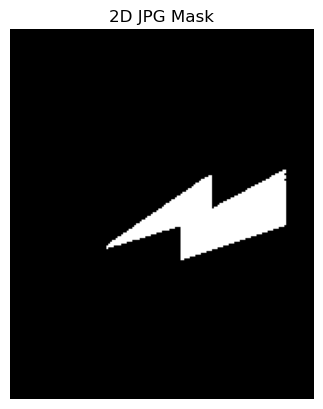

In [177]:
# Define the path to the bolt image
bolt_image_path = "/Users/cu135/Dropbox (Partners HealthCare)/resources/seeds/artistic/bolt.jpg"

# Define whether to fill the binary mask or not
fill_mask = True  # Set to True if you want the mask filled, else set to False

# Define the scaling factor for resizing the mask
scaling_factor = 1.0  # Change this value between 0 and 1 for downscaling, >1 for upscaling

# Initialize the JPGTracer with the provided configurations
tracer = JPGTracer(bolt_image_path,
                   fill_mask=fill_mask,
                   scaling_factor=scaling_factor,
                   rotate_90=True,
                   horz_flip=False,
                   vert_flip=True)

# Visualize the processed binary mask
tracer.visualize()


In [233]:
import numpy as np
from skimage.transform import resize
import nibabel as nib
from skimage.feature import canny


class NiftiGenerator:
    def __init__(self, binary_mask, generate_outline=False, mask_shape=(20, 20, 20)):
        self.mask = binary_mask
        self.generate_outline = generate_outline
        if self.generate_outline:
            mask_shape = list(mask_shape)
            mask_shape[0] += 2
            mask_shape[1] += 2
            mask_shape[2] += 3
            mask_shape = tuple(mask_shape)
        self.mask_shape = mask_shape

    def _calculate_offsets(self, img, img_shape, target_mni_coord=None):
        if target_mni_coord:
            # Convert MNI coordinates to array index
            array_coord = nib.affines.apply_affine(np.linalg.inv(img.affine), target_mni_coord)
            
            # Determine the offsets
            y_offset = int(array_coord[0] - self.mask_shape[0] // 2)
            x_offset = int(array_coord[1] - self.mask_shape[1] // 2)
            z_offset = int(array_coord[2] - self.mask_shape[2] // 2)

        else:
            y_offset = (img_shape[0] - self.mask_shape[0]) // 2
            x_offset = (img_shape[1] - self.mask_shape[1]) // 2
            z_offset = (img_shape[2] - self.mask_shape[2]) // 2

        return y_offset, x_offset, z_offset

    def _apply_canny_edge_detection(self, data):
        if len(data.shape) == 2:
            # Handle 2D data
            return canny(data)
        elif len(data.shape) == 3:
            # Handle 3D volume
            edges_3d = np.zeros_like(data)
            for z in range(data.shape[2]):
                edges_3d[:, :, z] = canny(data[:, :, z])
            return edges_3d
        else:
            raise ValueError("Unsupported data dimensions for edge detection.")


    def generate_nifti(self, img, output_file, orientation="axial", target_mni_coord=None):
        data = img.get_fdata().copy()
        data[:, :, :] = np.nan
        y_offset, x_offset, z_offset = self._calculate_offsets(img, data.shape, target_mni_coord)
        
        # Apply Canny edge detection to 2D mask
        edges = self._apply_canny_edge_detection(self.mask)
        self.mask = np.logical_or(self.mask, edges)
        
        # Resize the 2D mask (with clear edges) to 3D with the specified mask_shape
        resized_mask = resize(self.mask, self.mask_shape, mode='constant', preserve_range=True, order=0)

        if orientation == "axial":
            for z in range(self.mask_shape[2]):
                data[y_offset:y_offset+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z+z_offset] = resized_mask[:, :, z]
        elif orientation == "sagittal":
            for x in range(self.mask_shape[2]):
                data[x+x_offset, y_offset:y_offset+self.mask_shape[0], z_offset:z_offset+self.mask_shape[1]] = resized_mask[:, :, x]
        elif orientation == "coronal":
            for y in range(self.mask_shape[2]):
                data[y_offset+y:y_offset+y+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z_offset:z_offset+self.mask_shape[2]] = resized_mask[:, :, y]
        
        if self.generate_outline:
            data[(data < 0.5) & (data > 0.025)] = 1
        else:
            data[(data > 0.05)] = 1
        
        data[data > 0.05] = 1
        new_img = nib.Nifti1Image(data, img.affine, img.header)
        nib.save(new_img, output_file)

    # def generate_nifti(self, img, output_file, orientation="axial", target_mni_coord=None):
    #     data = img.get_fdata().copy()
    #     data[:, :, :] = np.nan
    #     y_offset, x_offset, z_offset= self._calculate_offsets(img, data.shape, target_mni_coord)
    #     #edge detction
    #     edges = self._apply_canny_edge_detection(self.mask) 
    #     self.mask = np.logical_or(self.mask, edges)
    #     # Resize the 2D mask to 3D with the specified mask_shape
    #     resized_mask = resize(self.mask, self.mask_shape, mode='constant', preserve_range=True)#, order=0)

    #     if orientation == "axial":
    #         for z in range(self.mask_shape[2]):
    #             data[y_offset:y_offset+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z+z_offset] = resized_mask[:, :, z]
    #     elif orientation == "sagittal":
    #         for x in range(self.mask_shape[2]):
    #             data[x+x_offset, y_offset:y_offset+self.mask_shape[0], z_offset:z_offset+self.mask_shape[1]] = resized_mask[:, :, x]
    #     elif orientation == "coronal":
    #         for y in range(self.mask_shape[2]):
    #             data[y_offset+y:y_offset+y+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z_offset:z_offset+self.mask_shape[2]] = resized_mask[:, :, y]
        
    #     new_img = nib.Nifti1Image(data, img.affine, img.header)
    #     nib.save(new_img, output_file)

In [214]:
    def generate_nifti(self, img, output_file, orientation="axial", target_mni_coord=None):
        data = img.get_fdata().copy()
        data[:, :, :] = np.nan
        y_offset, x_offset, z_offset = self._calculate_offsets(img, data.shape, target_mni_coord)
        
        # Apply Canny edge detection to 2D mask
        edges = self._apply_canny_edge_detection(self.mask)
        self.mask = np.logical_or(self.mask, edges)
        
        # Resize the 2D mask (with clear edges) to 3D with the specified mask_shape
        resized_mask = resize(self.mask, self.mask_shape, mode='constant', preserve_range=True, order=0)

        if orientation == "axial":
            for z in range(self.mask_shape[2]):
                data[y_offset:y_offset+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z+z_offset] = resized_mask[:, :, z]
        elif orientation == "sagittal":
            for x in range(self.mask_shape[2]):
                data[x+x_offset, y_offset:y_offset+self.mask_shape[0], z_offset:z_offset+self.mask_shape[1]] = resized_mask[:, :, x]
        elif orientation == "coronal":
            for y in range(self.mask_shape[2]):
                data[y_offset+y:y_offset+y+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z_offset:z_offset+self.mask_shape[2]] = resized_mask[:, :, y]
        
        if self.generate_outline:
            data[(data < 0.5) & (data > 0.025)] = 1
        else:
            data[(data > 0.05)] = 1
        
        data[data > 0.05] = 1
        new_img = nib.Nifti1Image(data, img.affine, img.header)
        nib.save(new_img, output_file)

Without Canny

In [238]:
import numpy as np
from skimage.transform import resize
import nibabel as nib
from skimage.feature import canny


class NiftiGenerator:
    def __init__(self, binary_mask, generate_outline=False, mask_shape=(20, 20, 20)):
        self.mask = binary_mask
        self.generate_outline = generate_outline
        if self.generate_outline:
            mask_shape = list(mask_shape)
            mask_shape[0] += 2
            mask_shape[1] += 2
            mask_shape[2] += 3
            mask_shape = tuple(mask_shape)
        self.mask_shape = mask_shape

    def _calculate_offsets(self, img, img_shape, target_mni_coord=None):
        if target_mni_coord:
            # Convert MNI coordinates to array index
            array_coord = nib.affines.apply_affine(np.linalg.inv(img.affine), target_mni_coord)
            
            # Determine the offsets
            y_offset = int(array_coord[0] - self.mask_shape[0] // 2)
            x_offset = int(array_coord[1] - self.mask_shape[1] // 2)
            z_offset = int(array_coord[2] - self.mask_shape[2] // 2)

        else:
            y_offset = (img_shape[0] - self.mask_shape[0]) // 2
            x_offset = (img_shape[1] - self.mask_shape[1]) // 2
            z_offset = (img_shape[2] - self.mask_shape[2]) // 2

        return y_offset, x_offset, z_offset

    def generate_nifti(self, img, output_file, orientation="axial", target_mni_coord=None):
        data = img.get_fdata().copy()
        data[:, :, :] = np.nan
        y_offset, x_offset, z_offset= self._calculate_offsets(img, data.shape, target_mni_coord)
        # Resize the 2D mask to 3D with the specified mask_shape
        resized_mask = resize(self.mask, self.mask_shape, mode='constant', preserve_range=True)#, order=0)

        if orientation == "axial":
            for z in range(self.mask_shape[2]):
                data[y_offset:y_offset+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z+z_offset] = resized_mask[:, :, z]
        elif orientation == "sagittal":
            for x in range(self.mask_shape[2]):
                data[x+x_offset, y_offset:y_offset+self.mask_shape[0], z_offset:z_offset+self.mask_shape[1]] = resized_mask[:, :, x]
        elif orientation == "coronal":
            for y in range(self.mask_shape[2]):
                data[y_offset+y:y_offset+y+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z_offset:z_offset+self.mask_shape[2]] = resized_mask[:, :, y]
        if self.generate_outline:
            data[(data < 0.5) & (data > 0.025)] = 1
        else:
            data[(data > 0.05)] = 1
        new_img = nib.Nifti1Image(data, img.affine, img.header)
        nib.save(new_img, output_file)

With Canny

In [219]:
import numpy as np
from skimage.transform import resize
import nibabel as nib
from skimage.feature import canny


class NiftiGenerator:
    def __init__(self, binary_mask, generate_outline=False, mask_shape=(20, 20, 20)):
        self.mask = binary_mask
        self.generate_outline = generate_outline
        if self.generate_outline:
            mask_shape = list(mask_shape)
            mask_shape[0] += 2
            mask_shape[1] += 2
            mask_shape[2] += 3
            mask_shape = tuple(mask_shape)
        self.mask_shape = mask_shape

    def _calculate_offsets(self, img, img_shape, target_mni_coord=None):
        if target_mni_coord:
            # Convert MNI coordinates to array index
            array_coord = nib.affines.apply_affine(np.linalg.inv(img.affine), target_mni_coord)
            
            # Determine the offsets
            y_offset = int(array_coord[0] - self.mask_shape[0] // 2)
            x_offset = int(array_coord[1] - self.mask_shape[1] // 2)
            z_offset = int(array_coord[2] - self.mask_shape[2] // 2)

        else:
            y_offset = (img_shape[0] - self.mask_shape[0]) // 2
            x_offset = (img_shape[1] - self.mask_shape[1]) // 2
            z_offset = (img_shape[2] - self.mask_shape[2]) // 2

        return y_offset, x_offset, z_offset

    def _apply_canny_edge_detection(self, data):
        if len(data.shape) == 2:
            # Handle 2D data
            return canny(data)
        elif len(data.shape) == 3:
            # Handle 3D volume
            edges_3d = np.zeros_like(data)
            for z in range(data.shape[2]):
                edges_3d[:, :, z] = canny(data[:, :, z])
            return edges_3d
        else:
            raise ValueError("Unsupported data dimensions for edge detection.")


    def generate_nifti(self, img, output_file, orientation="axial", target_mni_coord=None):
        data = img.get_fdata().copy()
        data[:, :, :] = np.nan
        y_offset, x_offset, z_offset = self._calculate_offsets(img, data.shape, target_mni_coord)
        
        # Apply Canny edge detection to 2D mask
        edges = self._apply_canny_edge_detection(self.mask)
        self.mask = np.logical_or(self.mask, edges)
        
        # Resize the 2D mask (with clear edges) to 3D with the specified mask_shape
        resized_mask = resize(self.mask, self.mask_shape, mode='constant', preserve_range=True, order=0)

        if orientation == "axial":
            for z in range(self.mask_shape[2]):
                data[y_offset:y_offset+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z+z_offset] = resized_mask[:, :, z]
        elif orientation == "sagittal":
            for x in range(self.mask_shape[2]):
                data[x+x_offset, y_offset:y_offset+self.mask_shape[0], z_offset:z_offset+self.mask_shape[1]] = resized_mask[:, :, x]
        elif orientation == "coronal":
            for y in range(self.mask_shape[2]):
                data[y_offset+y:y_offset+y+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z_offset:z_offset+self.mask_shape[2]] = resized_mask[:, :, y]
        
        data[data > 0.05] = 1
        new_img = nib.Nifti1Image(data, img.affine, img.header)
        nib.save(new_img, output_file)

    # def generate_nifti(self, img, output_file, orientation="axial", target_mni_coord=None):
    #     data = img.get_fdata().copy()
    #     data[:, :, :] = np.nan
    #     y_offset, x_offset, z_offset= self._calculate_offsets(img, data.shape, target_mni_coord)
    #     #edge detction
    #     edges = self._apply_canny_edge_detection(self.mask) 
    #     self.mask = np.logical_or(self.mask, edges)
    #     # Resize the 2D mask to 3D with the specified mask_shape
    #     resized_mask = resize(self.mask, self.mask_shape, mode='constant', preserve_range=True)#, order=0)

    #     if orientation == "axial":
    #         for z in range(self.mask_shape[2]):
    #             data[y_offset:y_offset+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z+z_offset] = resized_mask[:, :, z]
    #     elif orientation == "sagittal":
    #         for x in range(self.mask_shape[2]):
    #             data[x+x_offset, y_offset:y_offset+self.mask_shape[0], z_offset:z_offset+self.mask_shape[1]] = resized_mask[:, :, x]
    #     elif orientation == "coronal":
    #         for y in range(self.mask_shape[2]):
    #             data[y_offset+y:y_offset+y+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z_offset:z_offset+self.mask_shape[2]] = resized_mask[:, :, y]
        
    #     new_img = nib.Nifti1Image(data, img.affine, img.header)
    #     nib.save(new_img, output_file)

Canny Switch

In [248]:
import numpy as np
from skimage.transform import resize
import nibabel as nib
from skimage.feature import canny


class NiftiGenerator:
    def __init__(self, binary_mask, generate_outline=False, mask_shape=(20, 20, 20)):
        self.mask = binary_mask
        self.generate_outline = generate_outline
        if self.generate_outline:
            mask_shape = list(mask_shape)
            mask_shape[0] += 2
            mask_shape[1] += 2
            mask_shape[2] += 3
            mask_shape = tuple(mask_shape)
        else:
            mask_shape = list(mask_shape)
            mask_shape[0] += 2
            mask_shape[1] += 2
            mask_shape[2] += 0
            mask_shape = tuple(mask_shape)
        self.mask_shape = mask_shape

    def _calculate_offsets(self, img, img_shape, target_mni_coord=None):
        if target_mni_coord:
            # Convert MNI coordinates to array index
            array_coord = nib.affines.apply_affine(np.linalg.inv(img.affine), target_mni_coord)
            
            # Determine the offsets
            y_offset = int(array_coord[0] - self.mask_shape[0] // 2)
            x_offset = int(array_coord[1] - self.mask_shape[1] // 2)
            z_offset = int(array_coord[2] - self.mask_shape[2] // 2)

        else:
            y_offset = (img_shape[0] - self.mask_shape[0]) // 2
            x_offset = (img_shape[1] - self.mask_shape[1]) // 2
            z_offset = (img_shape[2] - self.mask_shape[2]) // 2

        return y_offset, x_offset, z_offset
    
    def _apply_canny_edge_detection(self, data):
        if len(data.shape) == 2:
            # Handle 2D data
            return canny(data)
        elif len(data.shape) == 3:
            # Handle 3D volume
            edges_3d = np.zeros_like(data)
            for z in range(data.shape[2]):
                edges_3d[:, :, z] = canny(data[:, :, z])
            return edges_3d
        else:
            raise ValueError("Unsupported data dimensions for edge detection.")


    def generate_nifti(self, img, output_file, orientation="axial", target_mni_coord=None):
        data = img.get_fdata().copy()
        data[:, :, :] = np.nan
        y_offset, x_offset, z_offset= self._calculate_offsets(img, data.shape, target_mni_coord)
        
        if self.generate_outline:
            # Resize the 2D mask to 3D with the specified mask_shape
            resized_mask = resize(self.mask, self.mask_shape, mode='constant', preserve_range=True)#, order=0)

            if orientation == "axial":
                for z in range(self.mask_shape[2]):
                    data[y_offset:y_offset+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z+z_offset] = resized_mask[:, :, z]
            elif orientation == "sagittal":
                for x in range(self.mask_shape[2]):
                    data[x+x_offset, y_offset:y_offset+self.mask_shape[0], z_offset:z_offset+self.mask_shape[1]] = resized_mask[:, :, x]
            elif orientation == "coronal":
                for y in range(self.mask_shape[2]):
                    data[y_offset+y:y_offset+y+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z_offset:z_offset+self.mask_shape[2]] = resized_mask[:, :, y]
            if self.generate_outline:
                data[(data < 0.5) & (data > 0.025)] = 1
            else:
                data[(data > 0.05)] = 1
            new_img = nib.Nifti1Image(data, img.affine, img.header)
            nib.save(new_img, output_file)
        else:
            # Apply Canny edge detection to 2D mask
            edges = self._apply_canny_edge_detection(self.mask)
            self.mask = np.logical_or(self.mask, edges)
            
            # Resize the 2D mask (with clear edges) to 3D with the specified mask_shape
            resized_mask = resize(self.mask, self.mask_shape, mode='constant', preserve_range=True, order=0)

            if orientation == "axial":
                for z in range(self.mask_shape[2]):
                    data[y_offset:y_offset+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z+z_offset] = resized_mask[:, :, z]
            elif orientation == "sagittal":
                for x in range(self.mask_shape[2]):
                    data[x+x_offset, y_offset:y_offset+self.mask_shape[0], z_offset:z_offset+self.mask_shape[1]] = resized_mask[:, :, x]
            elif orientation == "coronal":
                for y in range(self.mask_shape[2]):
                    data[y_offset+y:y_offset+y+self.mask_shape[0], x_offset:x_offset+self.mask_shape[1], z_offset:z_offset+self.mask_shape[2]] = resized_mask[:, :, y]
            
            data[data > 0.05] = 1
            new_img = nib.Nifti1Image(data, img.affine, img.header)
            nib.save(new_img, output_file)

In [261]:
from nimlab import datasets as nimds

# Load the MNI mask
mni_mask = nimds.get_img("mni_icbm152")

# Initialize the NiftiGenerator with the provided configurations
generator = NiftiGenerator(tracer.lightning_bolt_mask_2d, 
                           generate_outline=True,
                           mask_shape=(40, 50, 10))

# Generate the NIfTI file with the lightning bolt mask
generator.generate_nifti(mni_mask, 
                         "/Users/cu135/Dropbox (Partners HealthCare)/resources/seeds/artistic/lightning_bolt_test_edge.nii", 
                         orientation="sagittal",
                         target_mni_coord=(0,2,-8))
